<a href="https://colab.research.google.com/github/Ahmed-Camara/Facial-Emotion-Detection-using-deep-learning/blob/main/Human_face_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization,ZeroPadding2D, Activation
from tensorflow.keras.utils import plot_model 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [2]:
import cv2
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

dataset_path = '/content/drive/MyDrive/ML_DL_practice/Human Face Emotion Detection/data/archive.zip'
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

In [5]:
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [6]:
os.listdir(train_path)

['neutral', 'sad', 'angry', 'disgust', 'fear', 'happy', 'surprise']

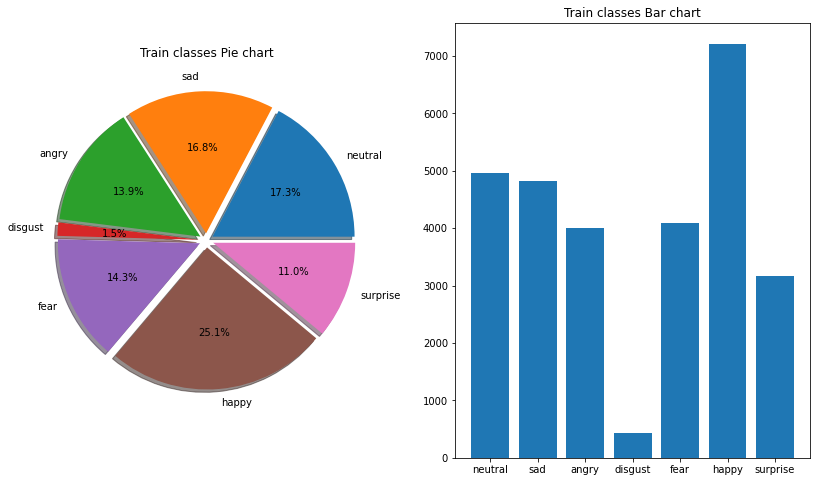

In [7]:
def get_counts(path):
  emotions = os.listdir(path)

  cls_counts = {}
  for emotion in emotions:
    count = len(os.listdir(os.path.join(path, emotion)))
    
    cls_counts[emotion] = count

  return cls_counts
train_counts = get_counts(train_path)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (14, 8))

explode = [0.05] * 7


ax0.set_title('Train classes Pie chart')
ax0.pie(train_counts.values(), labels=train_counts.keys(),
       explode=explode, autopct='%1.1f%%', shadow=True)
ax1.set_title('Train classes Bar chart')
ax1.bar(train_counts.keys(), train_counts.values(), width=0.8)


#fig.savefig('/content/pie_fer2013.png')
plt.show()

In [8]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    
    return image

#### Hyperparameters && parameters

In [9]:
BATCH_SIZE = 32 #64
IMAGE_SIZE = (224, 224)
epochs = 50
base_learning_rate = 0.001
fine_learning_rate = 1e-4
dropout_factor = 0.5

loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
fine_optimizer = tf.keras.optimizers.Adam(learning_rate=fine_learning_rate)
metrics=['accuracy']

#### Load data

In [10]:
train_dataset = image_dataset_from_directory(train_path,shuffle=True, batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE,validation_split=0.2,subset='training', seed = 42)
validation_dataset = image_dataset_from_directory(train_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,validation_split=0.2
                                                  ,subset='validation', seed = 42)

test_dataset = image_dataset_from_directory(test_path,shuffle=True, 
                                                  batch_size=BATCH_SIZE,image_size=IMAGE_SIZE
                                                  , seed = 42)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [11]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

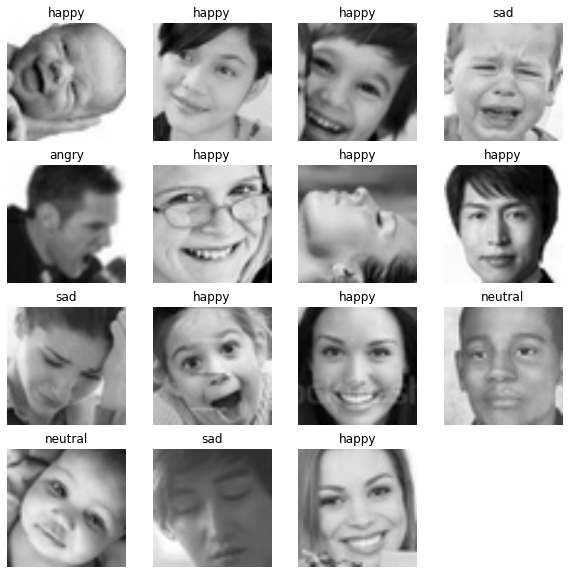

In [12]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [14]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

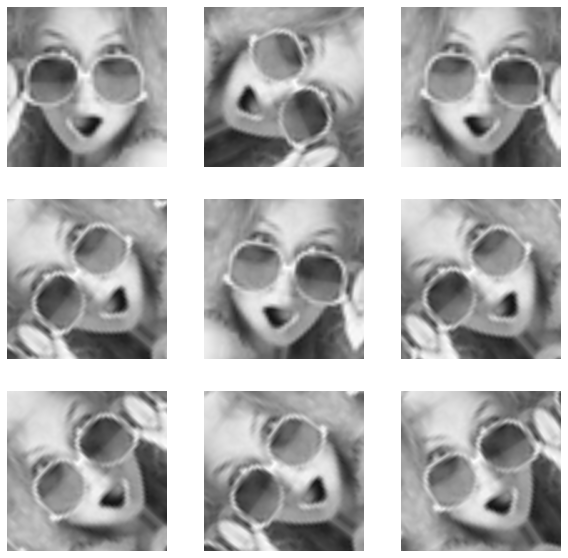

In [15]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In this project, we are using only transfer learning to build our models. First, we will train our model on top of the architecture then we will use fine-tuning model to increase our accuracy.

In [16]:
def draw_diagram(hist):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))


  ax0.plot(hist.history['accuracy'])
  ax0.plot(hist.history['val_accuracy'])
  ax0.set_title('Model Accuracy')
  ax0.set_xlabel('Epochs')
  ax0.set_ylabel('Accuracy')
  ax0.legend(['train', 'test'], loc='upper left')



  ax1.plot(hist.history['loss'])
  ax1.plot(hist.history['val_loss'])
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['train', 'test'], loc='upper left')

  fig.savefig('/content/fer_resutls.png')
  plt.show()

In [17]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

# Transfer Learning

##### Model function

In [18]:
def build_model(image_shape=IMAGE_SHAPE,data_augmentation=data_augmenter(),mod='mobile'):

  input_shape = image_shape + (3,)
  base_model = None
  preprocess_input = None

  if mod == 'mobile':
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
  elif mod == 'dense':
    preprocess_input = tf.keras.applications.densenet.preprocess_input
    base_model = tf.keras.applications.DenseNet201(input_shape=input_shape,include_top=False,weights='imagenet')
  
  elif mod == 'efficientnet':
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,include_top=False,weights='imagenet')
  
  elif mod == 'resnet':
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.ResNet101(input_shape=input_shape,include_top=False,weights='imagenet')
  
  base_model.trainable = False 
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(dropout_factor)(x)
  outputs = tfl.Dense(7)(x)
  model = tf.keras.Model(inputs, outputs)
  return base_model,model

##### callback Function

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, verbose=1, mode='min')
callbacks = [reduce_lr,stop_early]

### MobileNet

In [20]:
base_model, model = build_model(IMAGE_SIZE,data_augmentation,'mobile')

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
len(model.layers)

8

In [23]:
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
718/718 [==============================] - 96s 116ms/step - loss: 1.8872 - accuracy: 0.3053 - val_loss: 1.5712 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 2/50
718/718 [==============================] - 82s 114ms/step - loss: 1.6798 - accuracy: 0.3597 - val_loss: 1.6026 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 3/50
718/718 [==============================] - 82s 114ms/step - loss: 1.6550 - accuracy: 0.3641 - val_loss: 1.5604 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 4/50
718/718 [==============================] - 82s 114ms/step - loss: 1.6497 - accuracy: 0.3667 - val_loss: 1.6310 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 5/50
718/718 [==============================] - 82s 114ms/step - loss: 1.6431 - accuracy: 0.3747 - val_loss: 1.5544 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 6/50
718/718 [==============================] - 82s 114ms/step - loss: 1.6424 - accuracy: 0.3754 - val_loss: 1.5167 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 7/50
718/718 [==============================] 

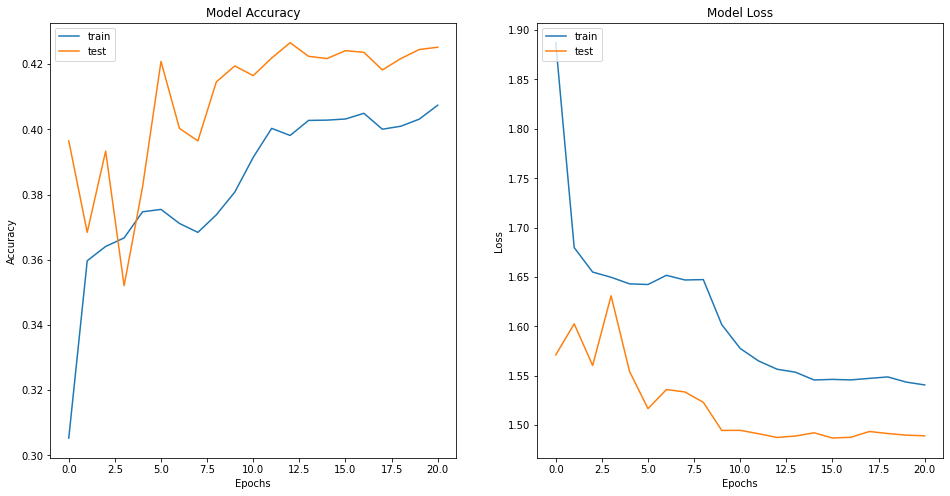

In [24]:
draw_diagram(history)

Let's do some fine-tuning to improve the result above.

##### fine-tuning

In [ ]:
base_model = model.layers[4]
base_model.trainable = True

fine_tune_at = 120


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)

fine_epochs = history.epoch[-1] + 100

history_fine = model.fit(train_dataset,
                         epochs=fine_epochs,batch_size=BATCH_SIZE,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

Epoch 21/120
718/718 [==============================] - 104s 138ms/step - loss: 1.4893 - accuracy: 0.4292 - val_loss: 1.3777 - val_accuracy: 0.4802 - lr: 1.0000e-05
Epoch 22/120
718/718 [==============================] - 98s 137ms/step - loss: 1.4219 - accuracy: 0.4505 - val_loss: 1.3237 - val_accuracy: 0.4971 - lr: 1.0000e-05
Epoch 23/120
718/718 [==============================] - 98s 136ms/step - loss: 1.3675 - accuracy: 0.4794 - val_loss: 1.2815 - val_accuracy: 0.5170 - lr: 1.0000e-05
Epoch 24/120
718/718 [==============================] - 98s 136ms/step - loss: 1.3285 - accuracy: 0.4952 - val_loss: 1.2605 - val_accuracy: 0.5168 - lr: 1.0000e-05
Epoch 25/120
718/718 [==============================] - 98s 136ms/step - loss: 1.2980 - accuracy: 0.5073 - val_loss: 1.2264 - val_accuracy: 0.5295 - lr: 1.0000e-05
Epoch 26/120
718/718 [==============================] - 98s 137ms/step - loss: 1.2725 - accuracy: 0.5164 - val_loss: 1.2018 - val_accuracy: 0.5393 - lr: 1.0000e-05
Epoch 27/120
71

In [ ]:
draw_diagram(history_fine)

#### DenseNet

In [ ]:
base_model, dense_model = build_model(IMAGE_SIZE,data_augmentation,'dense')

In [ ]:
dense_model.summary()

In [ ]:
len(dense_model.layers)

In [ ]:
dense_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = dense_model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

In [ ]:
draw_diagram(history)

In [ ]:
base_model = dense_model.layers[5]
base_model.trainable = True

fine_tune_at = 670


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
fine_epochs = history.epoch[-1] + 100


dense_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)

history_fine = dense_model.fit(train_dataset,
                         epochs=fine_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

In [ ]:
draw_diagram(history_fine)

### EfficientNetV2M

In [ ]:
base_model,eff_model = build_model(IMAGE_SIZE, data_augmentation,'efficientnet')
eff_model.summary()

In [ ]:
eff_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = eff_model.fit(train_dataset,
                         epochs=epochs,batch_size=BATCH_SIZE,
                         validation_data=validation_dataset,callbacks=callbacks)

##### fine-tuning

In [ ]:
base_model = eff_model.layers[2]
base_model.trainable = True

fine_tune_at = 200


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    

eff_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)

fine_epochs = history.epoch[-1] + 100

history_fine = eff_model.fit(train_dataset,
                         epochs=fine_epochs,batch_size=BATCH_SIZE,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,callbacks=callbacks)

In [ ]:
draw_diagram(history_fine)

### Resnet101

In [ ]:
base_model,res_model = build_model(IMAGE_SIZE, data_augmentation,'resnet')
res_model.summary()

In [ ]:
base_model = res_model.layers[4]
base_model.trainable = True

fine_tune_at = 300


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    


res_model.compile(loss=loss_function,
              optimizer = fine_optimizer,
              metrics=metrics)
history_fine = res_model.fit(train_dataset,
                         epochs=fine_epochs,
                         validation_data=validation_dataset,callbacks=callbacks)

In [ ]:
draw_diagram(history_fine)